In [32]:
from google.colab import files
uploaded = files.upload()

Saving listingsSF.csv to listingsSF.csv
Saving reviewsSF.csv to reviewsSF.csv


In [33]:
import pandas as pd
from sklearn.utils import resample
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from bs4 import BeautifulSoup
import re

listings = pd.read_csv(io.BytesIO(uploaded['listingsSF.csv']))
reviews = pd.read_csv(io.BytesIO(uploaded['reviewsSF.csv']))

# Data Cleaning

Checking all the attributes in the daatset


In [34]:
print(listings.columns)
print(reviews.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

Removing unnecessary attributes from the daatset

In [35]:
#Before Dropping
print(listings.shape)

listings = listings.drop(['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'calendar_updated','license','calendar_last_scraped'], axis=1)

#After dropping
print(listings.shape)

(7807, 75)
(7807, 59)


Price column has \$ symbol and cannot be processed as a numerical column. So, removing the \$ sign and converting it to float

In [36]:
# Ensure that the 'price' column is treated as a string first
listings['price'] = listings['price'].astype(str)

# Remove the $ symbol and commas using regex, then convert to numeric
listings['price'] = listings['price'].str.replace(r'[$,]', '', regex=True)

# Convert the cleaned 'price' column to a numeric type
listings['price'] = pd.to_numeric(listings['price'], errors='coerce')

# Check the result
print(listings['price'].head())
print(listings['price'].dtype)

0      NaN
1      NaN
2    132.0
3      NaN
4      NaN
Name: price, dtype: float64
float64


Checking if any of the numerical attributes have string or text data

In [37]:
# Convert the specified columns to numeric, coerce errors to NaN
cols_to_check = ['price','minimum_nights','maximum_nights','number_of_reviews','bedrooms', 'bathrooms', 'beds', 'accommodates',
                 'availability_30', 'availability_365', 'number_of_reviews_ltm','review_scores_rating']

# Function to check if values are non-numeric
def count_non_numeric(series):
    # This will return True for non-numeric values (strings or text)
    return series.apply(pd.to_numeric, errors='coerce').isna().sum()

# Apply the function to each column and get the count of non-numeric rows per column
non_numeric_counts = listings[cols_to_check].apply(count_non_numeric)

# Output the result
print("Number of rows with non-numeric values for each column:")
print(non_numeric_counts)



Number of rows with non-numeric values for each column:
price                    1649
minimum_nights              0
maximum_nights              0
number_of_reviews           0
bedrooms                  456
bathrooms                1654
beds                     1705
accommodates                0
availability_30             0
availability_365            0
number_of_reviews_ltm       0
review_scores_rating     1771
dtype: int64


Cleaning the text attributes room_type

In [38]:
# Remove leading/trailing spaces
listings['room_type'] = listings['room_type'].str.strip()

# Standardize text to lowercase
listings['room_type'] = listings['room_type'].str.lower()


Checking for missing values in the text attributes room_type and neighbourhood_cleansed

In [39]:
import pandas as pd

# Specify the columns to check for missing values
columns_to_check = ['room_type', 'neighbourhood_cleansed']

# Get the count of missing values for the specified columns
missing_values = listings[columns_to_check].isnull().sum()

# Display the number of missing values for these columns
print(missing_values)


room_type                 0
neighbourhood_cleansed    0
dtype: int64


Converting the amenities in each row into a numerical attribute in order to be used for further analysis.

In [40]:
# Function to clean and count the number of amenities in each record
def count_amenities(amenities_str):
    # Decode special characters and remove unnecessary characters like quotes, square brackets, etc.
    cleaned_amenities_str = amenities_str.encode('utf-8').decode('unicode_escape').strip('[]').replace('"', '')

    # Split the cleaned string into a list of amenities
    amenities_list = cleaned_amenities_str.split(', ')

    # Return the count of amenities
    return len(amenities_list)

# Apply the function to each record in the 'amenities' column
listings['amenities_count'] = listings['amenities'].apply(lambda x: count_amenities(x))

# Display the updated DataFrame with the new column
print(listings[['amenities', 'amenities_count']])

                                              amenities  amenities_count
0     ["Essentials", "Kitchen", "Stainless steel sto...               23
1     ["Hair dryer", "Courtyard view", "Essentials",...               68
2     ["Shared hot tub", "Hair dryer", "Courtyard vi...               62
3     ["Shared hot tub", "Hair dryer", "Courtyard vi...               53
4     ["Hair dryer", "Courtyard view", "Essentials",...               60
...                                                 ...              ...
7802  ["Hair dryer", "Elevator", "Essentials", "Heat...               36
7803  ["Hair dryer", "Shampoo", "Essentials", "Dryer...               15
7804  ["Hair dryer", "Essentials", "Private entrance...               13
7805  ["Hair dryer", "Essentials", "Private entrance...               56
7806  ["Hair dryer", "Essentials", "Private entrance...               40

[7807 rows x 2 columns]


# Descriptive Statistics

Calculate summary statistics for numerical features such as `price`,
`minimum_nights`, `maximum_nights`, `number_of_reviews`, and
`review_scores_rating`. Understand the central tendency, dispersion, and
distribution of these variables.

In [41]:
# List of numerical features to analyze
numerical_features = ['price','minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating']

# Additional features for analysis
additional_numerical_features = ['accommodates','availability_30', 'availability_365', 'number_of_reviews_ltm']

Removing null values from the required numerical features

In [42]:
# Convert columns to numeric, invalid parsing will be set as NaN
listings[numerical_features] = listings[numerical_features].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns (i.e., non-numeric values)
listings_1 = listings.dropna(subset=numerical_features)

# Check the DataFrame to ensure non-numeric values have been removed
print(listings_1)

# Verify that all specified columns are numerical
print(listings_1[numerical_features].dtypes)

                      id                                               name  \
2     623833252305593889         Massive 1-bedroom condo in the heart of SF   
6               51508029  Orange Village Hostel -Full Size Bed w/shared ...   
8     565272991337321502   Orange Village Hostel- 3  Bed Room w/shared bath   
9               50489340   Orange Village Hostel - Full Size Bed w/Bathroom   
10              50623131       Orange Village Hostel - Twin Beds w/Bathroom   
...                  ...                                                ...   
7800            10550345                Timeshare - Club Donatello Union-Sq   
7802             1018426  SHARE Spacious Loft: Moscone, Ball Park & Down...   
7803             1059961                       KelSoMa 1 Bed & Bath in SoMa   
7805  619605575248018100    Elegant & Chic Home with Magic Garden in Bernal   
7806             5242394                      Private Cozy Studio Flat  4U!   

                                            descrip

Calculating the summary statistics for the required numerical values

In [43]:
def display_summary_statistics(dataframe, numerical_features):
    # Calculate summary statistics
    summary_statistics = dataframe[numerical_features].describe()

    # Display the summary statistics
    print("Summary Statistics:")
    print(summary_statistics)

numerical_features = ['price', 'minimum_nights','maximum_nights', 'review_scores_rating']
display_summary_statistics(listings_1, numerical_features)


Summary Statistics:
              price  minimum_nights  maximum_nights  review_scores_rating
count   4891.000000      4891.00000     4891.000000           4891.000000
mean     234.636066        16.61971      583.399714              4.790681
std     1050.443381        31.58870    14300.886054              0.374915
min       25.000000         1.00000        1.000000              1.000000
25%       99.000000         2.00000       29.000000              4.750000
50%      148.000000         3.00000      182.000000              4.910000
75%      235.000000        30.00000      365.000000              5.000000
max    50000.000000       365.00000   999999.000000              5.000000


Removing null values from the additional numerical features

In [44]:
# Convert columns to numeric, invalid parsing will be set as NaN
listings[additional_numerical_features] = listings[additional_numerical_features].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns (i.e., non-numeric values)
listings_2 = listings.dropna(subset=additional_numerical_features)

# Check the DataFrame to ensure non-numeric values have been removed
print(listings_2)

# Verify that all specified columns are numerical
print(listings_2[additional_numerical_features].dtypes)

                      id                                               name  \
0               50489368  (B) Furnished Efficiency Studio near Union Square   
1               53687935   2 Private Rooms in SF. Walk to Bart. Modern Home   
2     623833252305593889         Massive 1-bedroom condo in the heart of SF   
3               53817024      Large 1-bedroom in a condo in the heart of SF   
4               54381390                Cozy 1-bedroom condo with roof deck   
...                  ...                                                ...   
7802             1018426  SHARE Spacious Loft: Moscone, Ball Park & Down...   
7803             1059961                       KelSoMa 1 Bed & Bath in SoMa   
7804            27558226  SanFrancisco Fully Furnished Studio/Apt clean&...   
7805  619605575248018100    Elegant & Chic Home with Magic Garden in Bernal   
7806             5242394                      Private Cozy Studio Flat  4U!   

                                            descrip

Calculating the summary statistics for the additional numerical features

In [45]:
display_summary_statistics(listings_2, additional_numerical_features)

Summary Statistics:
       accommodates  availability_30  availability_365  number_of_reviews_ltm
count   7807.000000      7807.000000       7807.000000            7807.000000
mean       3.201614        11.304214        181.709620               8.701934
std        1.989553        11.497989        133.364698              18.817044
min        1.000000         0.000000          0.000000               0.000000
25%        2.000000         0.000000         54.000000               0.000000
50%        2.000000         7.000000        175.000000               1.000000
75%        4.000000        23.000000        320.000000               7.000000
max       16.000000        30.000000        365.000000             378.000000


Calculating the values variance, skewness, kurtosis for understanding the central tendency, dispersion

In [46]:
# Calculate variance
variance_values1 = listings_1[numerical_features].var()
variance_values2 = listings_2[additional_numerical_features].var()
print("\nVariance Values:")
print(variance_values1)
print(variance_values2)

# Calculate skewness
skewness_values1 = listings_1[numerical_features].skew()
skewness_values2 = listings_2[additional_numerical_features].skew()
print("\nSkewness Values:")
print(skewness_values1)
print(skewness_values2)

# Calculate kurtosis
kurtosis_values1 = listings_1[numerical_features].kurt()
kurtosis_values2 = listings_2[additional_numerical_features].kurt()
print("\nKurtosis Values:")
print(kurtosis_values1)
print(kurtosis_values2)


Variance Values:
price                   1.103431e+06
minimum_nights          9.978459e+02
maximum_nights          2.045153e+08
review_scores_rating    1.405615e-01
dtype: float64
accommodates                 3.958322
availability_30            132.203752
availability_365         17786.142545
number_of_reviews_ltm      354.081143
dtype: float64

Skewness Values:
price                   43.799150
minimum_nights           8.265359
maximum_nights          69.826285
review_scores_rating    -4.914173
dtype: float64
accommodates             1.929671
availability_30          0.504203
availability_365        -0.005453
number_of_reviews_ltm    5.469706
dtype: float64

Kurtosis Values:
price                   2061.836944
minimum_nights            86.345122
maximum_nights          4880.785404
review_scores_rating      35.649865
dtype: float64
accommodates              6.002919
availability_30          -1.357825
availability_365         -1.480067
number_of_reviews_ltm    58.812402
dtype: float64


# 2. Distribution Analysis

Plot histograms or density plots for key numerical features like price,minimum_nights, and review_scores_rating. Analyze the distribution of these features to identify any skewness or outliers.

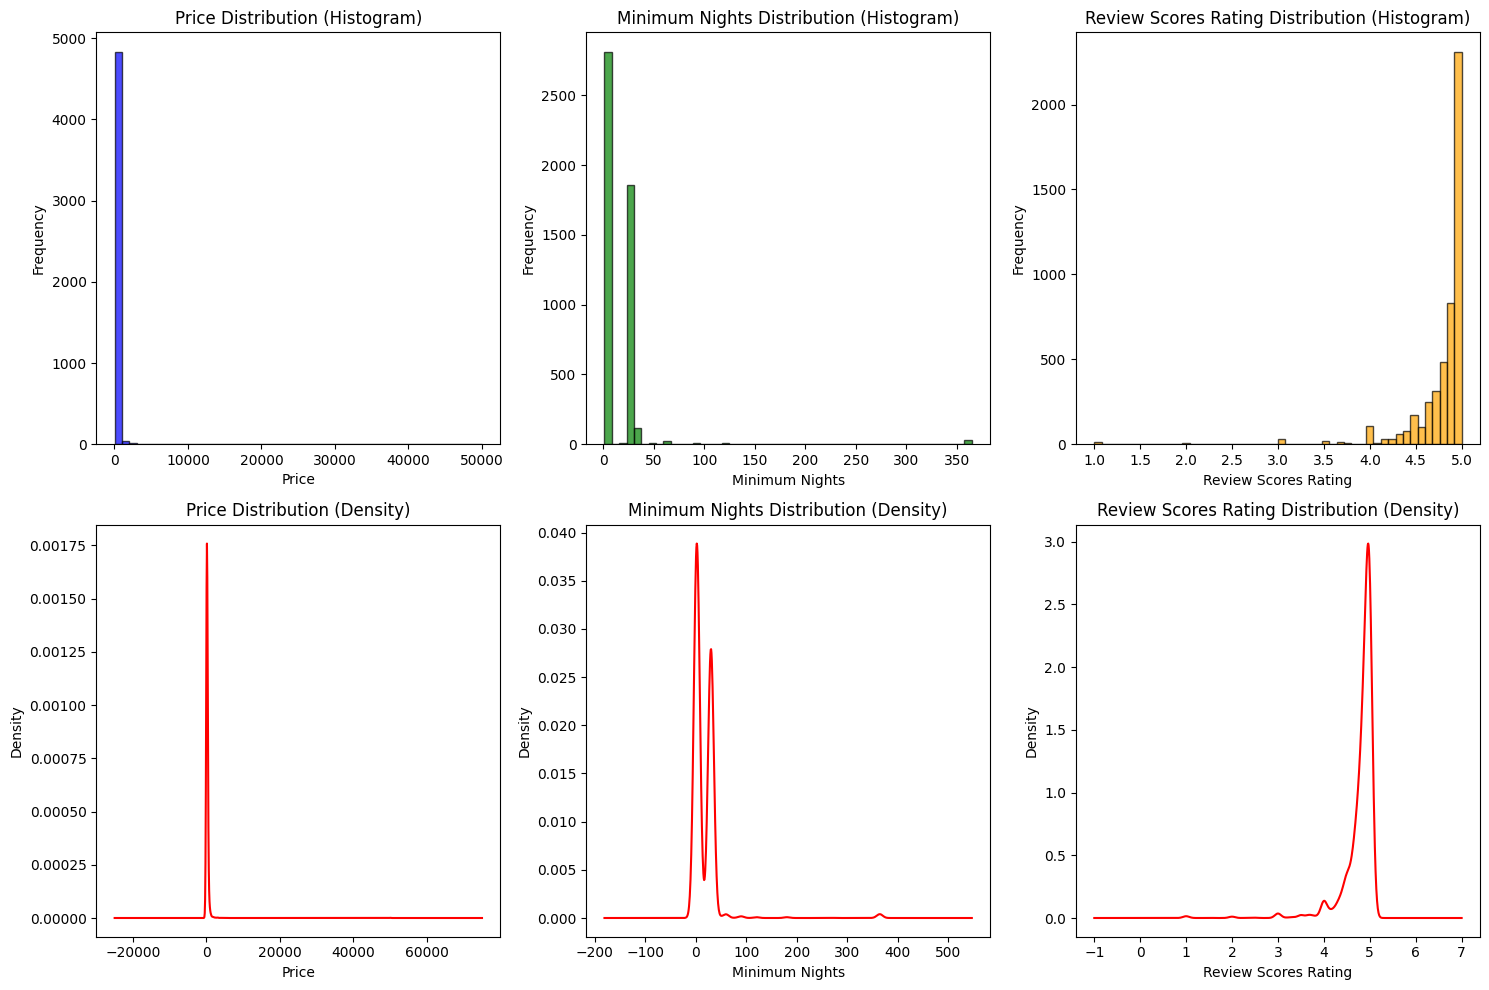

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_numerical_distributions(dataframe):
    """
    Plot histograms and density plots for key numerical features in the DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the numerical features.
    """
    plt.figure(figsize=(15, 10))

    # Price histogram
    plt.subplot(2, 3, 1)
    plt.hist(dataframe['price'], bins=50, color='blue', edgecolor='black', alpha=0.7)
    plt.title('Price Distribution (Histogram)')
    plt.xlabel('Price')
    plt.ylabel('Frequency')

    # Price density plot
    plt.subplot(2, 3, 4)
    dataframe['price'].plot(kind='kde', color='red')
    plt.title('Price Distribution (Density)')
    plt.xlabel('Price')
    plt.ylabel('Density')

    # Minimum nights histogram
    plt.subplot(2, 3, 2)
    plt.hist(dataframe['minimum_nights'], bins=50, color='green', edgecolor='black', alpha=0.7)
    plt.title('Minimum Nights Distribution (Histogram)')
    plt.xlabel('Minimum Nights')
    plt.ylabel('Frequency')

    # Minimum nights density plot
    plt.subplot(2, 3, 5)
    dataframe['minimum_nights'].plot(kind='kde', color='red')
    plt.title('Minimum Nights Distribution (Density)')
    plt.xlabel('Minimum Nights')
    plt.ylabel('Density')

    # Review scores rating histogram
    plt.subplot(2, 3, 3)
    plt.hist(dataframe['review_scores_rating'].dropna(), bins=50, color='orange', edgecolor='black', alpha=0.7)
    plt.title('Review Scores Rating Distribution (Histogram)')
    plt.xlabel('Review Scores Rating')
    plt.ylabel('Frequency')

    # Review scores rating density plot
    plt.subplot(2, 3, 6)
    dataframe['review_scores_rating'].dropna().plot(kind='kde', color='red')
    plt.title('Review Scores Rating Distribution (Density)')
    plt.xlabel('Review Scores Rating')
    plt.ylabel('Density')

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_numerical_distributions(listings_1)


# 3. Correlation Analysis

Create a correlation matrix to explore relationships between numerical variables such as price, number_of_reviews, availability_365, and review_scores_rating. Identify any strong correlations that might be useful for predictive modeling or further investigation.

Plotting correlation matrix and heatmap for the required attributes

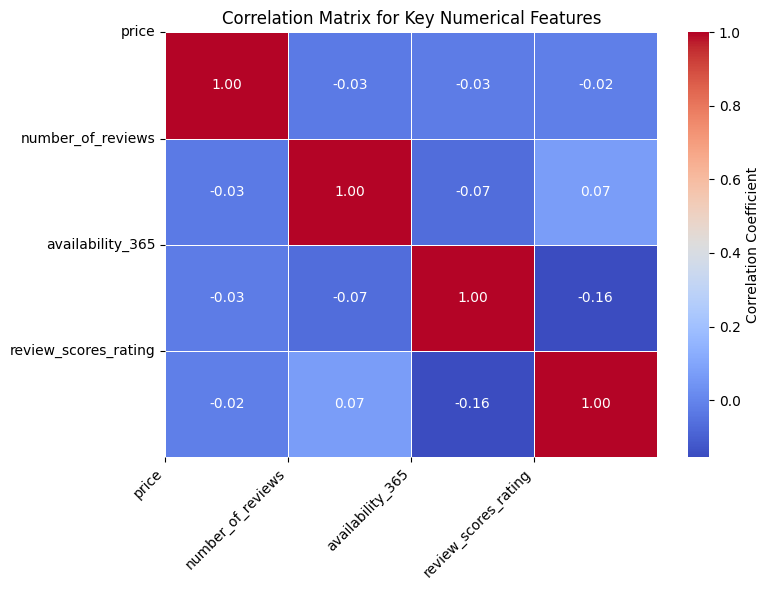

,price,number_of_reviews,availability_365,review_scores_rating
price,1.000000,-0.032059,-0.027463,-0.018464
number_of_reviews,-0.032059,1.000000,-0.066895,0.072505
availability_365,-0.027463,-0.066895,1.000000,-0.155338
review_scores_rating,-0.018464,0.072505,-0.155338,1.000000


In [48]:
#List of columns
correlation_columns = ['price', 'number_of_reviews', 'availability_365', 'review_scores_rating']

# Convert columns to numeric, invalid parsing will be set as NaN
listings[correlation_columns] = listings[correlation_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns
listings_3 = listings_1.dropna(subset=correlation_columns)

# Creating the correlation matrix
correlation_matrix = listings_3[correlation_columns].corr()

# Plotting the correlation matrix using a heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})

# Formatting the heatmap
plt.xticks(range(len(correlation_columns)), correlation_columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_columns)), correlation_columns)
plt.title('Correlation Matrix for Key Numerical Features')

# Show the plot
plt.tight_layout()
plt.show()

# Displaying the correlation matrix
correlation_matrix

Plotting correlation matrix and heatmap for additional attributes

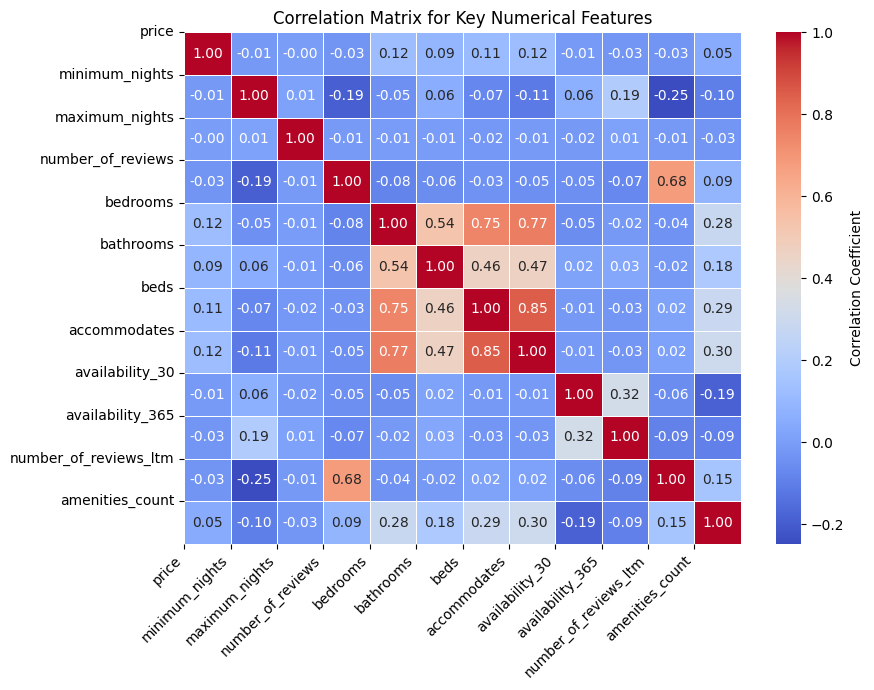

,price,minimum_nights,maximum_nights,number_of_reviews,bedrooms,bathrooms,beds,accommodates,availability_30,availability_365,number_of_reviews_ltm,amenities_count
price,1.000000,-0.014199,-0.002838,-0.032488,0.118520,0.090013,0.109653,0.120792,-0.013073,-0.027759,-0.028517,0.046292
minimum_nights,-0.014199,1.000000,0.013550,-0.190406,-0.045700,0.057290,-0.073751,-0.111950,0.061579,0.192666,-0.247259,-0.100228
maximum_nights,-0.002838,0.013550,1.000000,-0.010926,-0.006264,-0.006462,-0.021652,-0.009526,-0.015355,0.013396,-0.014598,-0.026809
number_of_reviews,-0.032488,-0.190406,-0.010926,1.000000,-0.084953,-0.056882,-0.034557,-0.050604,-0.047703,-0.067831,0.680494,0.085308
bedrooms,0.118520,-0.045700,-0.006264,-0.084953,1.000000,0.536527,0.750882,0.768100,-0.052661,-0.016540,-0.036722,0.279939
bathrooms,0.090013,0.057290,-0.006462,-0.056882,0.536527,1.000000,0.464638,0.465933,0.017536,0.033635,-0.016460,0.178996
beds,0.109653,-0.073751,-0.021652,-0.034557,0.750882,0.464638,1.000000,0.849401,-0.014297,-0.026392,0.019547,0.285595
accommodates,0.120792,-0.111950,-0.009526,-0.050604,0.768100,0.465933,0.849401,1.000000,-0.011397,-0.027472,0.015060,0.303533
availability_30,-0.013073,0.061579,-0.015355,-0.047703,-0.052661,0.017536,-0.014297,-0.011397,1.000000,0.324101,-0.057054,-0.188105
availability_365,-0.027759,0.192666,0.013396,-0.067831,-0.016540,0.033635,-0.026392,-0.027472,0.324101,1.000000,-0.087055,-0.091563


In [49]:
#List of columns
correlation_columns = ['price','minimum_nights','maximum_nights','number_of_reviews','bedrooms','bathrooms','beds','accommodates','availability_30','availability_365','number_of_reviews_ltm','amenities_count']

# Convert columns to numeric, invalid parsing will be set as NaN
listings[correlation_columns] = listings[correlation_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns
listings_4 = listings_1.dropna(subset=correlation_columns)

# Creating the correlation matrix
correlation_matrix = listings_4[correlation_columns].corr()

# Plotting the correlation matrix using a heatmap with annotations
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})

# Formatting the heatmap
plt.xticks(range(len(correlation_columns)), correlation_columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_columns)), correlation_columns)
plt.title('Correlation Matrix for Key Numerical Features')

# Show the plot
plt.tight_layout()
plt.show()

# Displaying the correlation matrix
correlation_matrix


# 4. Price Analysis

Analyze the distribution of prices across different neighborhoods (host_neighbourhood) or room types (if available). Understand which neighborhoods have higher or lower average prices and whether certain neighborhoods are more popular for shortterm or longterm stays.

In [50]:
listings['stay_type'] = listings['minimum_nights'].apply(lambda x: 'Long-term' if x > 30 else 'Short-term')

# Extracting relevant columns for price analysis: price, neighbourhood_cleansed, room_type, and minimum_nights
price_analysis_columns = ['price', 'neighbourhood_cleansed', 'room_type', 'minimum_nights', 'maximum_nights', 'stay_type']

# Creating the price_analysis_data DataFrame
price_analysis_data = listings[price_analysis_columns].dropna()

# Calculating average price per neighborhood
avg_price_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)

# Calculating average minimum/maximum nights per neighborhood (to understand short-term vs long-term stays)
avg_minimum_nights_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['minimum_nights'].mean().sort_values(ascending=False)
avg_maximum_nights_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['maximum_nights'].mean().sort_values(ascending=False)

# Calculating average price per room type
avg_price_room_type = price_analysis_data.groupby('room_type')['price'].mean().sort_values(ascending=False)

# Calculate average price for short-term and long-term stays by neighborhood
avg_price_neighbourhood_stay_type = price_analysis_data.groupby(['neighbourhood_cleansed', 'stay_type'])['price'].mean().unstack().fillna(0)

# Calculate average price for short-term and long-term stays by room type
avg_price_room_type_stay_type = price_analysis_data.groupby(['room_type', 'stay_type'])['price'].mean().unstack().fillna(0)

# Displaying the results
print("Average Price by Neighborhood:")
print(avg_price_neighbourhood)

print("\nAverage Minimum Nights by Neighborhood:")
print(avg_minimum_nights_neighbourhood)

print("\nAverage Maximum Nights by Neighborhood:")
print(avg_maximum_nights_neighbourhood)

print("\nAverage Price by Room Type:")
print(avg_price_room_type)

print("\nAverage Price by Neighborhood and Stay Type:")
print(avg_price_neighbourhood_stay_type)

print("\nAverage Price by Room Type and Stay Type:")
print(avg_price_room_type_stay_type)


Average Price by Neighborhood:
neighbourhood_cleansed
Castro/Upper Market      515.197531
Russian Hill             411.150685
Pacific Heights          377.529032
Western Addition         354.745921
Inner Richmond           351.016393
Financial District       348.696429
Presidio                 297.000000
Marina                   293.931579
Twin Peaks               290.851852
Diamond Heights          279.416667
Seacliff                 275.250000
North Beach              267.897638
Presidio Heights         260.529412
Haight Ashbury           249.753488
Noe Valley               248.741379
Potrero Hill             243.074074
Inner Sunset             235.127119
South of Market          222.128421
Bernal Heights           217.436364
Nob Hill                 201.533101
Treasure Island/YBI      200.000000
West of Twin Peaks       198.813953
Chinatown                198.463918
Downtown/Civic Center    197.287621
Glen Park                180.736842
Outer Richmond           178.608939
Mission   

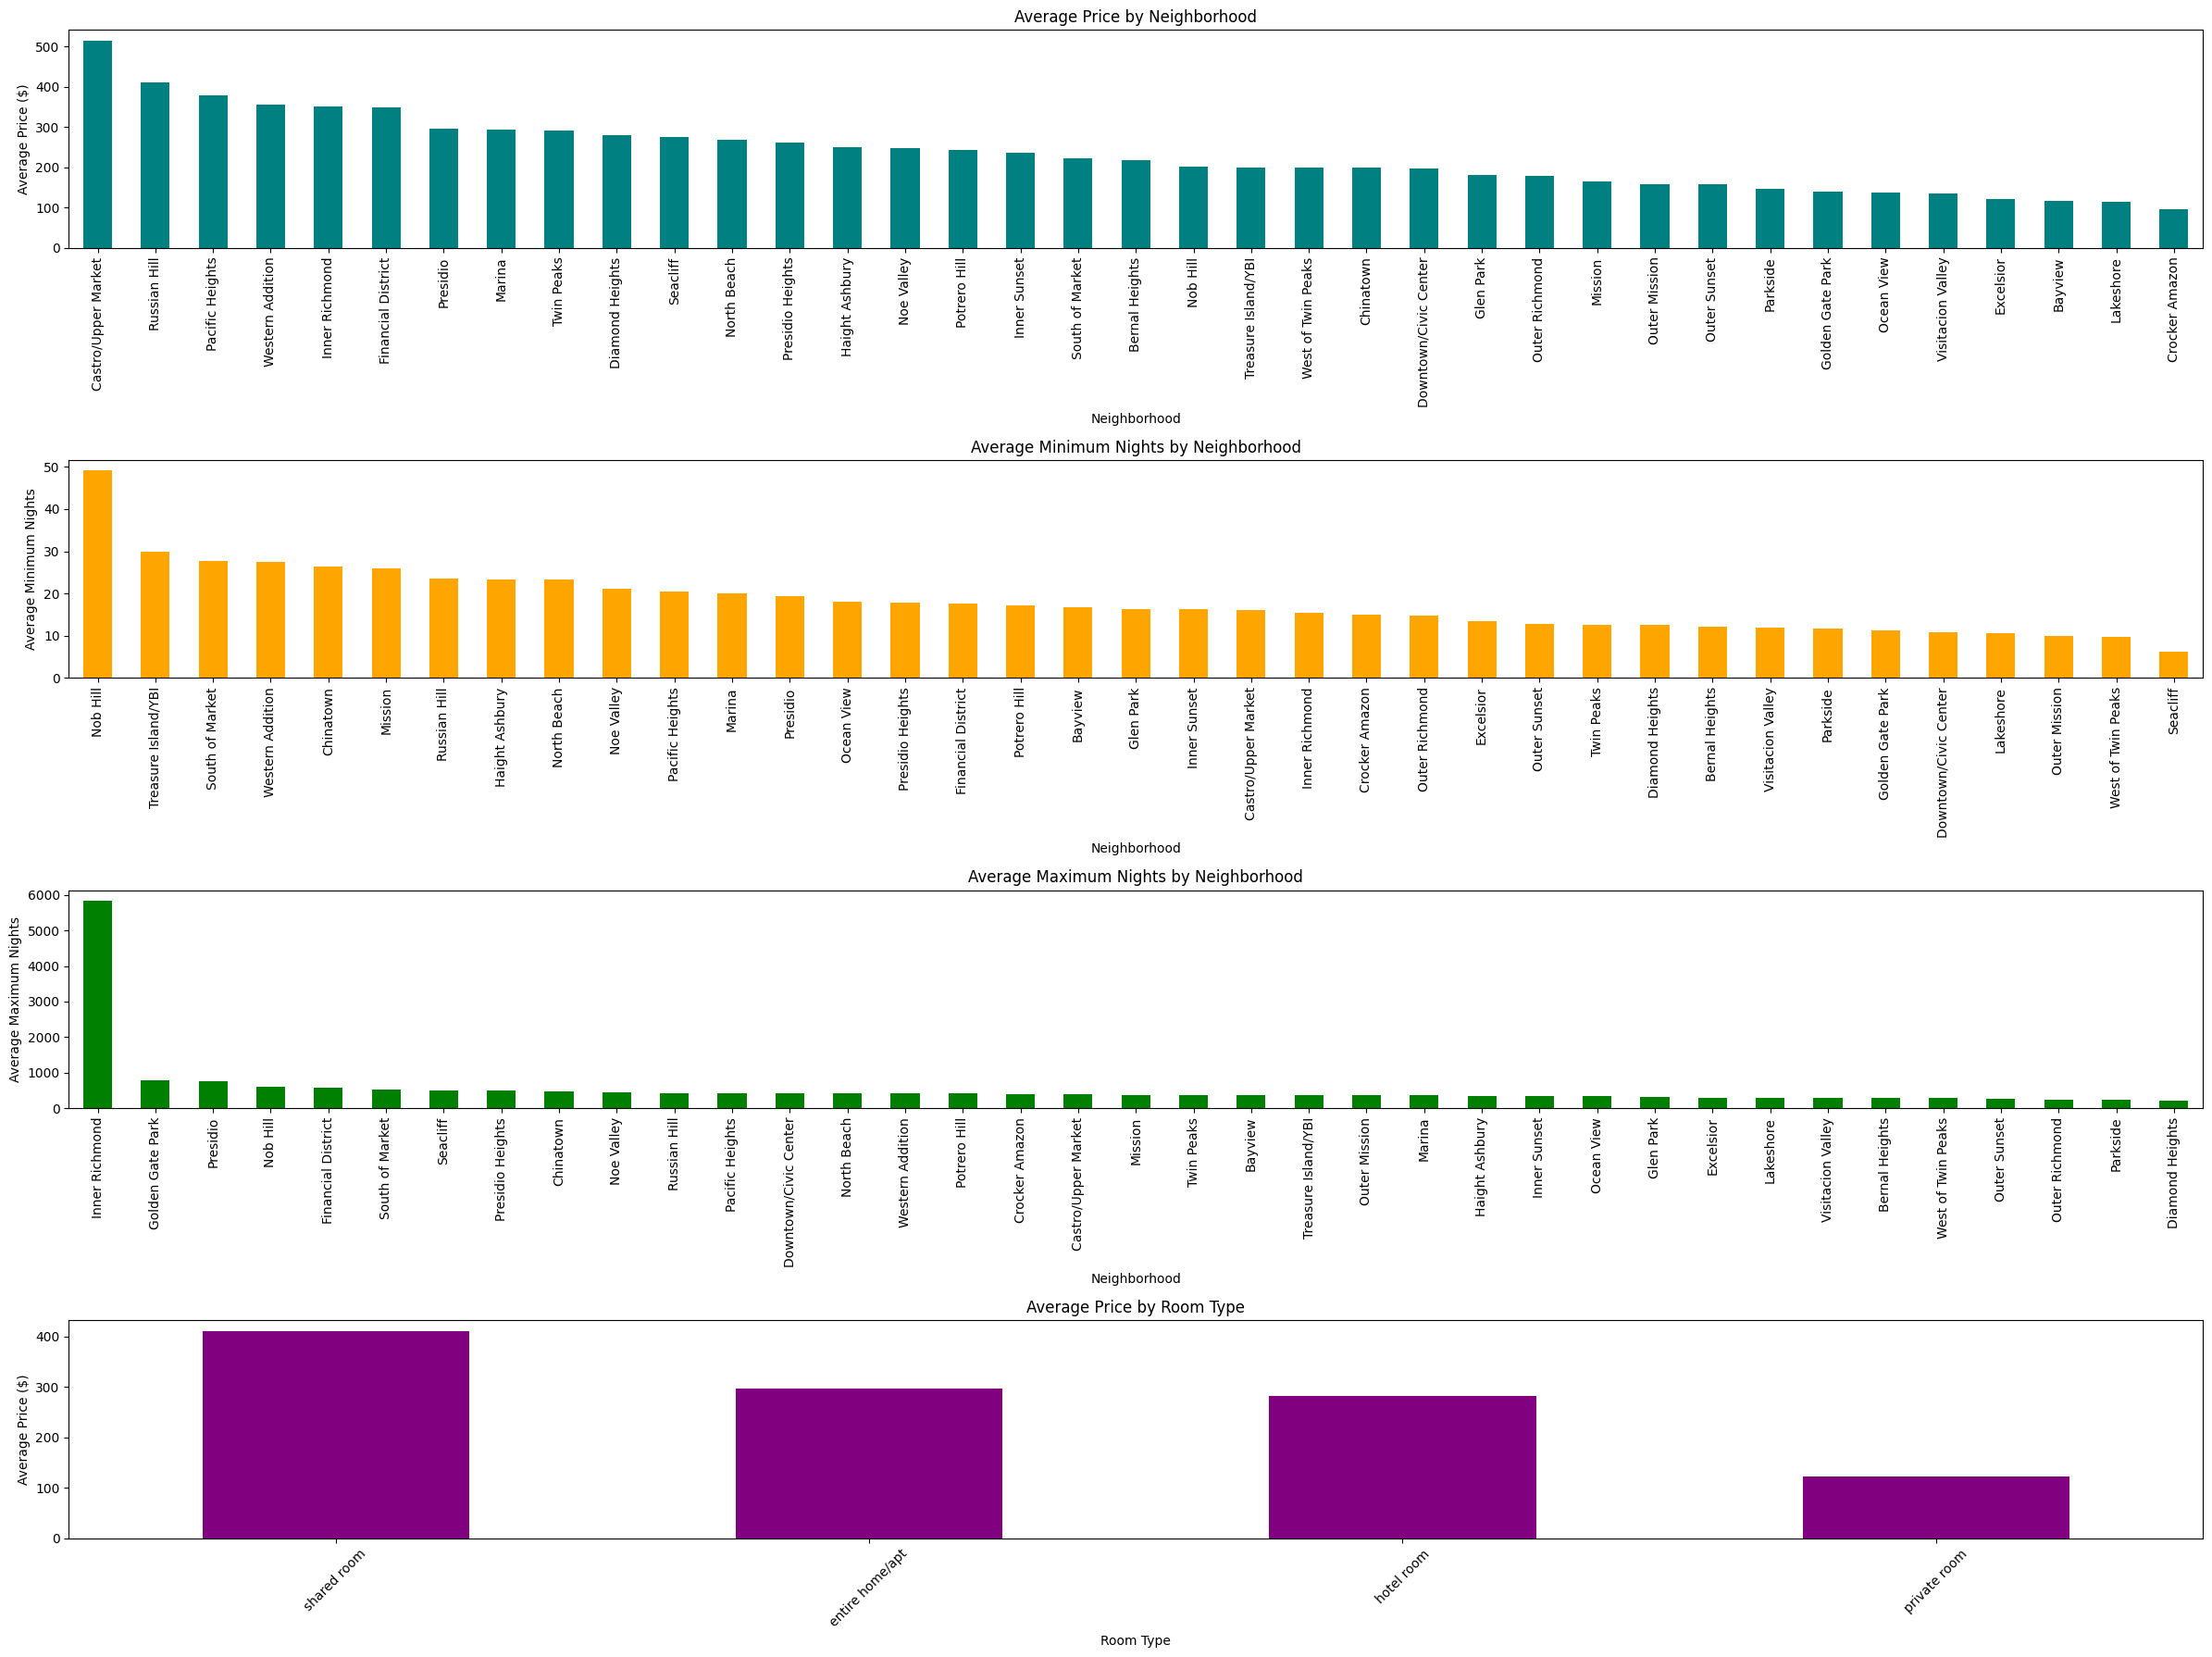

In [51]:
# Plotting price and minimum nights distributions across neighborhoods and room types
plt.figure(figsize=(24, 18))

# Average price by neighborhood
plt.subplot(4, 1, 1)
avg_price_neighbourhood.plot(kind='bar', color='teal')
plt.title('Average Price by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=90)

# Average minimum nights by neighborhood
plt.subplot(4, 1, 2)
avg_minimum_nights_neighbourhood.plot(kind='bar', color='orange')
plt.title('Average Minimum Nights by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Minimum Nights')
plt.xticks(rotation=90)

# Average maximum nights by neighborhood
plt.subplot(4, 1, 3)
avg_maximum_nights_neighbourhood.plot(kind='bar', color='green')
plt.title('Average Maximum Nights by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Maximum Nights')
plt.xticks(rotation=90)

# Average price by room type
plt.subplot(4, 1, 4)
avg_price_room_type.plot(kind='bar', color='purple')
plt.title('Average Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<Figure size 1600x800 with 0 Axes>

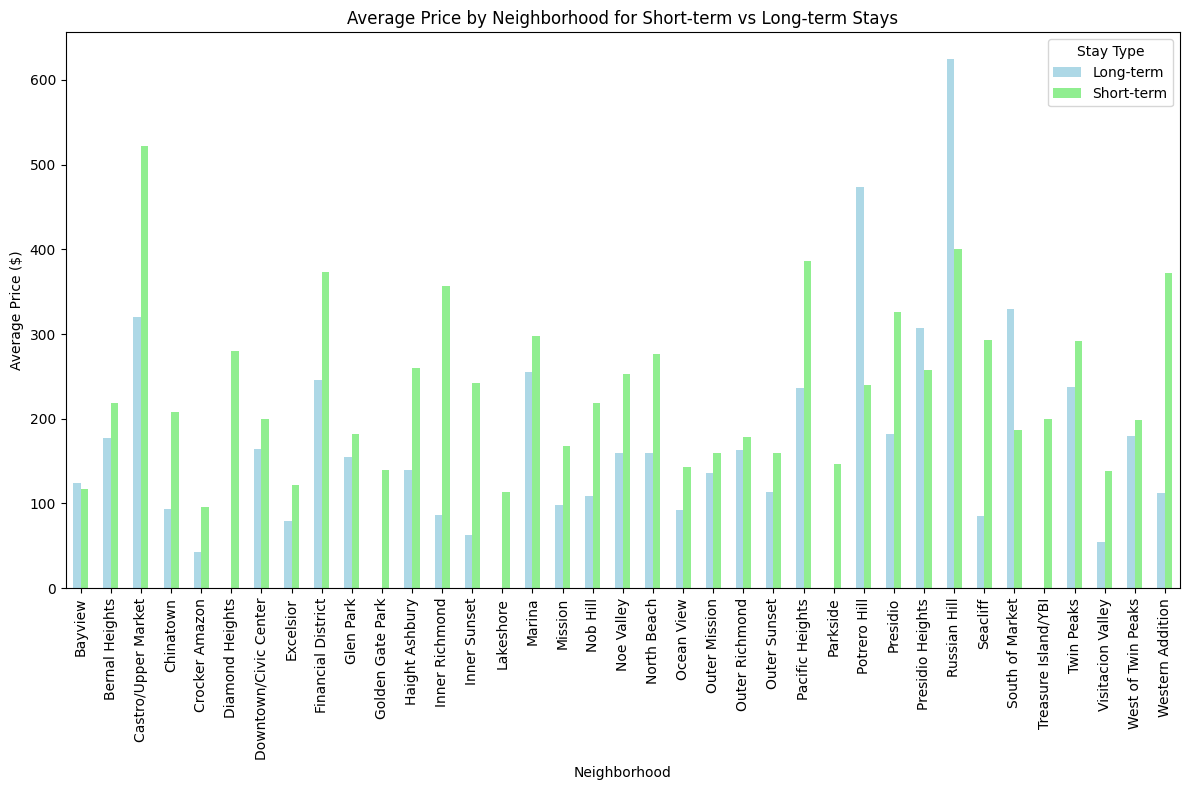

<Figure size 800x600 with 0 Axes>

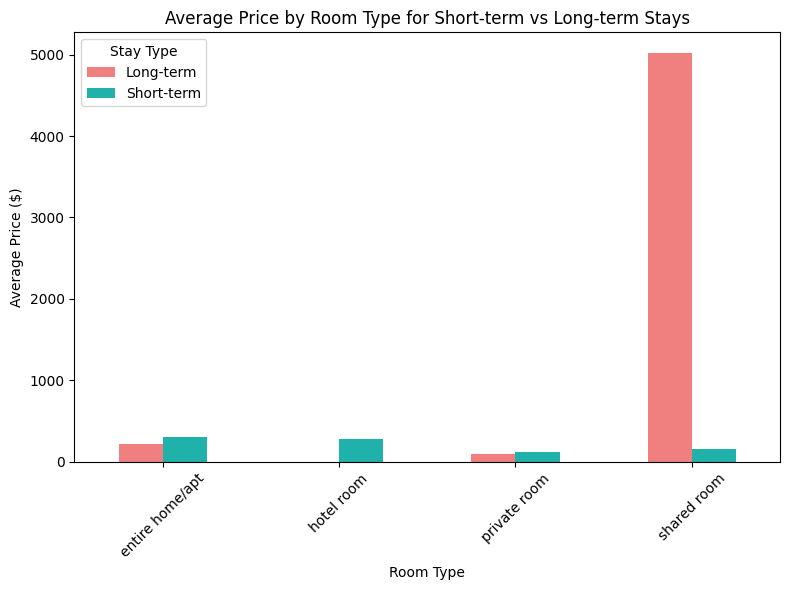

In [52]:
# Plotting average price by neighborhood for short-term and long-term stays
plt.figure(figsize=(16, 8))

# Average price by neighborhood for short-term and long-term stays
avg_price_neighbourhood_stay_type.plot(kind='bar', stacked=False, color=['lightblue', 'lightgreen'], figsize=(12, 8))
plt.title('Average Price by Neighborhood for Short-term vs Long-term Stays')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=90)
plt.legend(title='Stay Type')

plt.tight_layout()
plt.show()

# Plotting average price by room type for short-term and long-term stays
plt.figure(figsize=(8, 6))

# Average price by room type for short-term and long-term stays
avg_price_room_type_stay_type.plot(kind='bar', stacked=False, color=['lightcoral', 'lightseagreen'], figsize=(8, 6))
plt.title('Average Price by Room Type for Short-term vs Long-term Stays')
plt.xlabel('Room Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)
plt.legend(title='Stay Type')

plt.tight_layout()
plt.show()

# 5. Neighborhood Comparison

Compare the average review_scores_rating across different neighborhoods. Determine if certain neighborhoods have consistently higher ratings, which could indicate better or worse guest experiences.

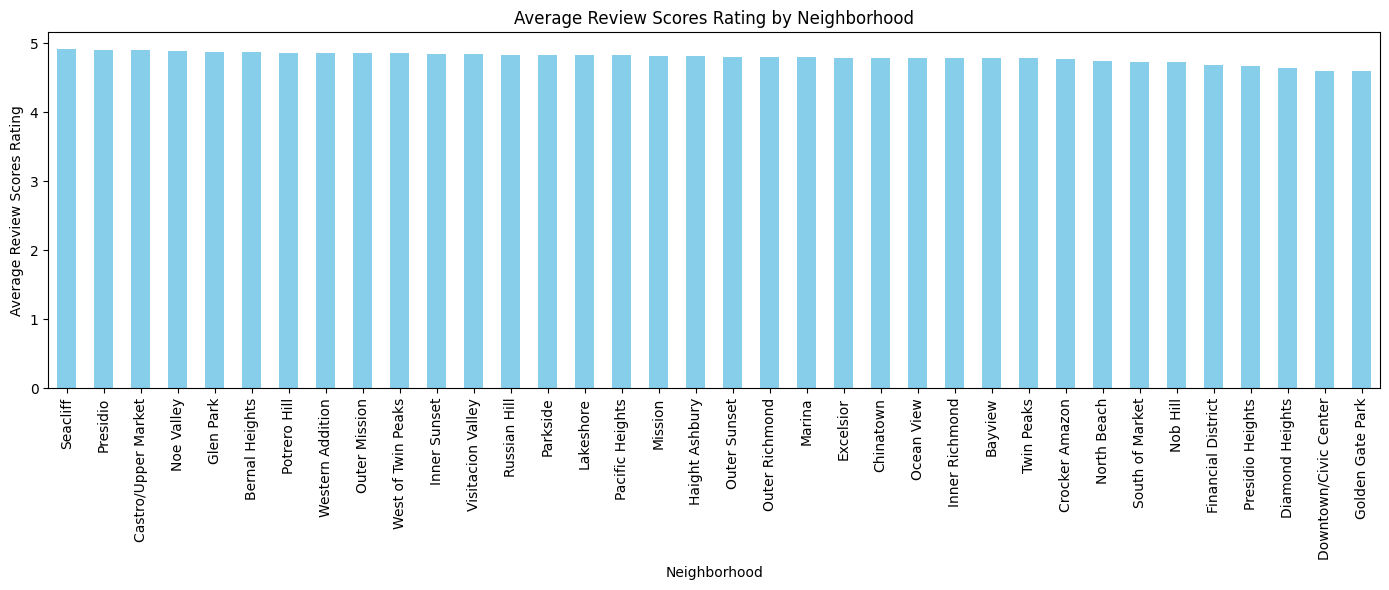

Average Review Scores Rating by Neighborhood:
neighbourhood_cleansed
Seacliff                 4.910833
Presidio                 4.903750
Castro/Upper Market      4.898295
Noe Valley               4.879476
Glen Park                4.876531
Bernal Heights           4.872199
Potrero Hill             4.861631
Western Addition         4.858079
Outer Mission            4.856102
West of Twin Peaks       4.850652
Inner Sunset             4.842362
Visitacion Valley        4.836061
Russian Hill             4.829184
Parkside                 4.824297
Lakeshore                4.824182
Pacific Heights          4.823444
Mission                  4.819865
Haight Ashbury           4.811496
Outer Sunset             4.803533
Outer Richmond           4.801351
Marina                   4.796987
Excelsior                4.789463
Chinatown                4.788981
Ocean View               4.788261
Inner Richmond           4.786235
Bayview                  4.780397
Twin Peaks               4.780182
Crocker Amazo

In [53]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculating average review_scores_rating per neighborhood
avg_rating_neighbourhood = listings.groupby('neighbourhood_cleansed')['review_scores_rating'].mean().dropna().sort_values(ascending=False)

# Plotting the average review_scores_rating across neighborhoods
plt.figure(figsize=(14, 6))
avg_rating_neighbourhood.plot(kind='bar', color='skyblue')
plt.title('Average Review Scores Rating by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Review Scores Rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Display the average review scores rating per neighborhood
print("Average Review Scores Rating by Neighborhood:")
print(avg_rating_neighbourhood)

# 6. Outlier Detection

Identify outliers in the dataset, particularly in price, minimum_nights, and review_scores_rating.

# Detecting outliers using IQR

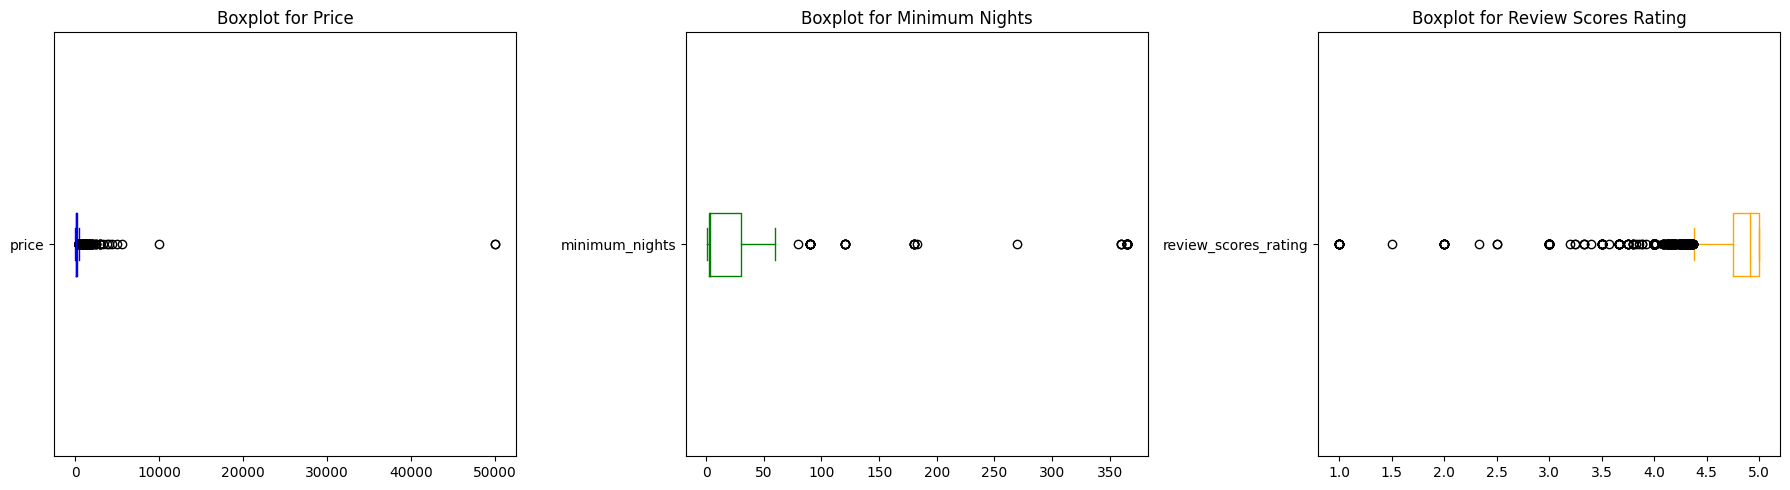

Number of price outliers: 395
        price
92      500.0
95     4950.0
447     850.0
626     536.0
797     585.0
...       ...
7716   1200.0
7737    549.0
7796    545.0
7798    631.0
7803  10000.0

[395 rows x 1 columns]

Number of minimum nights outliers: 55
      minimum_nights
549              120
550              120
552              120
553              120
989               90
1212             365
1214             365
1216             365
1660             365
1661             365
1662             365
1664             365
1667             365
1670             365
1678             365
1685             365
3368             365
3369             365
3370             365
3371             365
3372             365
3373             365
3374             365
3378             365
4814             365
4986             180
5188             365
5227              90
5731             183
5751             180
5946              90
5987             180
6175             365
6445              90
6446

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming listings_1 is your original DataFrame
# List of columns to check for outliers
outlier_columns = ['price', 'minimum_nights', 'review_scores_rating']

# Function to detect outliers using IQR
def detect_outliers_iqr(listings, column):
    Q1 = listings[column].quantile(0.25)
    Q3 = listings[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = listings[(listings[column] < lower_bound) | (listings[column] > upper_bound)]
    return outliers

# Detecting outliers for each column and storing them in separate DataFrames
outliers_price = detect_outliers_iqr(listings_1, 'price')
outliers_minimum_nights = detect_outliers_iqr(listings_1, 'minimum_nights')
outliers_review_scores = detect_outliers_iqr(listings_1, 'review_scores_rating')

# Combine all outliers into one DataFrame
all_outliers = pd.concat([outliers_price, outliers_minimum_nights, outliers_review_scores]).drop_duplicates()

# Create a DataFrame without outliers
listings_no_outliers_IQR = listings_1[~listings_1.index.isin(all_outliers.index)]

# Visualizing outliers with boxplots
plt.figure(figsize=(18, 5))

# Boxplot for price
plt.subplot(1, 3, 1)
listings_1['price'].plot(kind='box', vert=False, color='blue')
plt.title('Boxplot for Price')

# Boxplot for minimum nights
plt.subplot(1, 3, 2)
listings_1['minimum_nights'].plot(kind='box', vert=False, color='green')
plt.title('Boxplot for Minimum Nights')

# Boxplot for review scores rating
plt.subplot(1, 3, 3)
listings_1['review_scores_rating'].plot(kind='box', vert=False, color='orange')
plt.title('Boxplot for Review Scores Rating')

plt.tight_layout()
plt.show()

# Display the number of outliers
print(f"Number of price outliers: {len(outliers_price)}")
print(outliers_price[['price']])

print(f"\nNumber of minimum nights outliers: {len(outliers_minimum_nights)}")
print(outliers_minimum_nights[['minimum_nights']])

print(f"\nNumber of review scores rating outliers: {len(outliers_review_scores)}")
print(outliers_review_scores[['review_scores_rating']])

# Display the number of total outliers and save to separate DataFrame
print(f"\nTotal number of outliers detected: {len(all_outliers)}")
print(all_outliers)

# The listings_no_outliers_IQR DataFrame now contains the data without outliers


# Outlier Detection using Z Score Technique  

Number of outliers per column:
price                    14
minimum_nights          136
review_scores_rating    109
dtype: int64


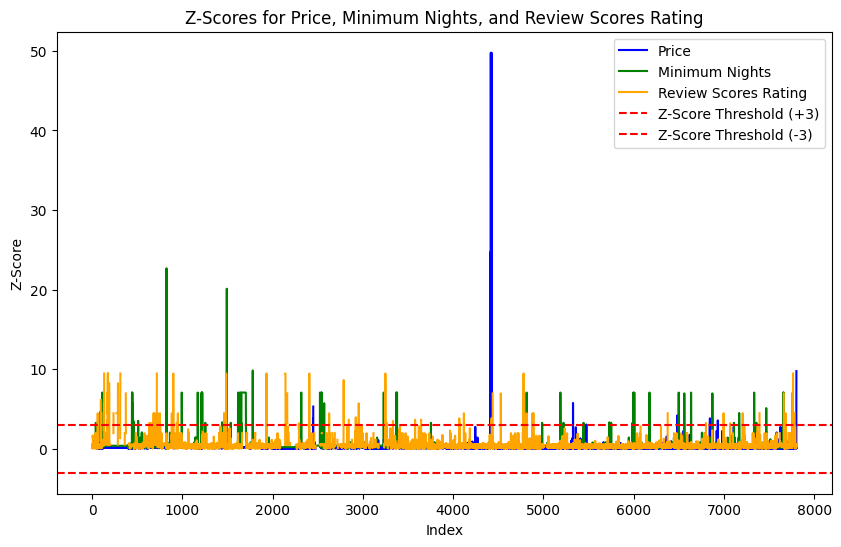

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def remove_outliers_z_score(dataframe, outlier_columns, threshold=3):
    """
    Remove outliers from the DataFrame using Z-Score method and store them in a new DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    outlier_columns (list): List of columns to check for outliers.
    threshold (float): Z-score threshold for detecting outliers (default is 3).

    Returns:
    pd.DataFrame: DataFrame without outliers.
    pd.Series: Series with the number of outliers detected per column.
    """
    # Standardizing (z-scoring) the data for outlier detection
    z_scores = np.abs((dataframe[outlier_columns] - dataframe[outlier_columns].mean()) / dataframe[outlier_columns].std())

    # Detecting outliers with a z-score threshold
    outliers = z_scores > threshold

    # Number of outliers per column
    outliers_per_column = outliers.sum()

    # Displaying the number of outliers per column
    print("Number of outliers per column:")
    print(outliers_per_column)

    # Remove outliers from the original DataFrame
    dataframe_no_outliers = dataframe[~outliers.any(axis=1)]

    # Plotting the z-scores with colors for each property
    plt.figure(figsize=(10, 6))

    # Plot each property with a different color
    plt.plot(z_scores['price'], label='Price', color='blue')
    plt.plot(z_scores['minimum_nights'], label='Minimum Nights', color='green')
    plt.plot(z_scores['review_scores_rating'], label='Review Scores Rating', color='orange')

    # Add z-score threshold line at the specified threshold
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Z-Score Threshold (+{threshold})')
    plt.axhline(y=-threshold, color='red', linestyle='--', label=f'Z-Score Threshold (-{threshold})')

    # Add labels and title
    plt.title('Z-Scores for Price, Minimum Nights, and Review Scores Rating')
    plt.xlabel('Index')
    plt.ylabel('Z-Score')

    # Add legend to show which color represents which property
    plt.legend()

    # Show the plot
    plt.show()

    return dataframe_no_outliers, outliers_per_column

listings_no_outliers_Z, outliers_per_column = remove_outliers_z_score(listings, outlier_columns)


Calculating summary statistics after dropping outliers according to IQR method

In [56]:
#IQR
display_summary_statistics(listings_no_outliers_IQR, numerical_features)

#Z Score
display_summary_statistics(listings_no_outliers_Z, numerical_features)

Summary Statistics:
             price  minimum_nights  maximum_nights  review_scores_rating
count  4096.000000     4096.000000     4096.000000           4096.000000
mean    163.360840       14.136963      371.454834              4.864143
std      87.829256       14.280140      468.348885              0.152721
min      25.000000        1.000000        1.000000              4.380000
25%      98.000000        2.000000       29.000000              4.790000
50%     142.000000        3.000000      180.000000              4.910000
75%     212.250000       30.000000      365.000000              5.000000
max     439.000000       60.000000    10000.000000              5.000000
Summary Statistics:
             price  minimum_nights  maximum_nights  review_scores_rating
count  5977.000000     7549.000000     7549.000000           5859.000000
mean    213.461436       14.851901      516.728308              4.828433
std     228.471465       15.831303    11513.898189              0.238254
min      25

Visualizing after outlier removal using IQR

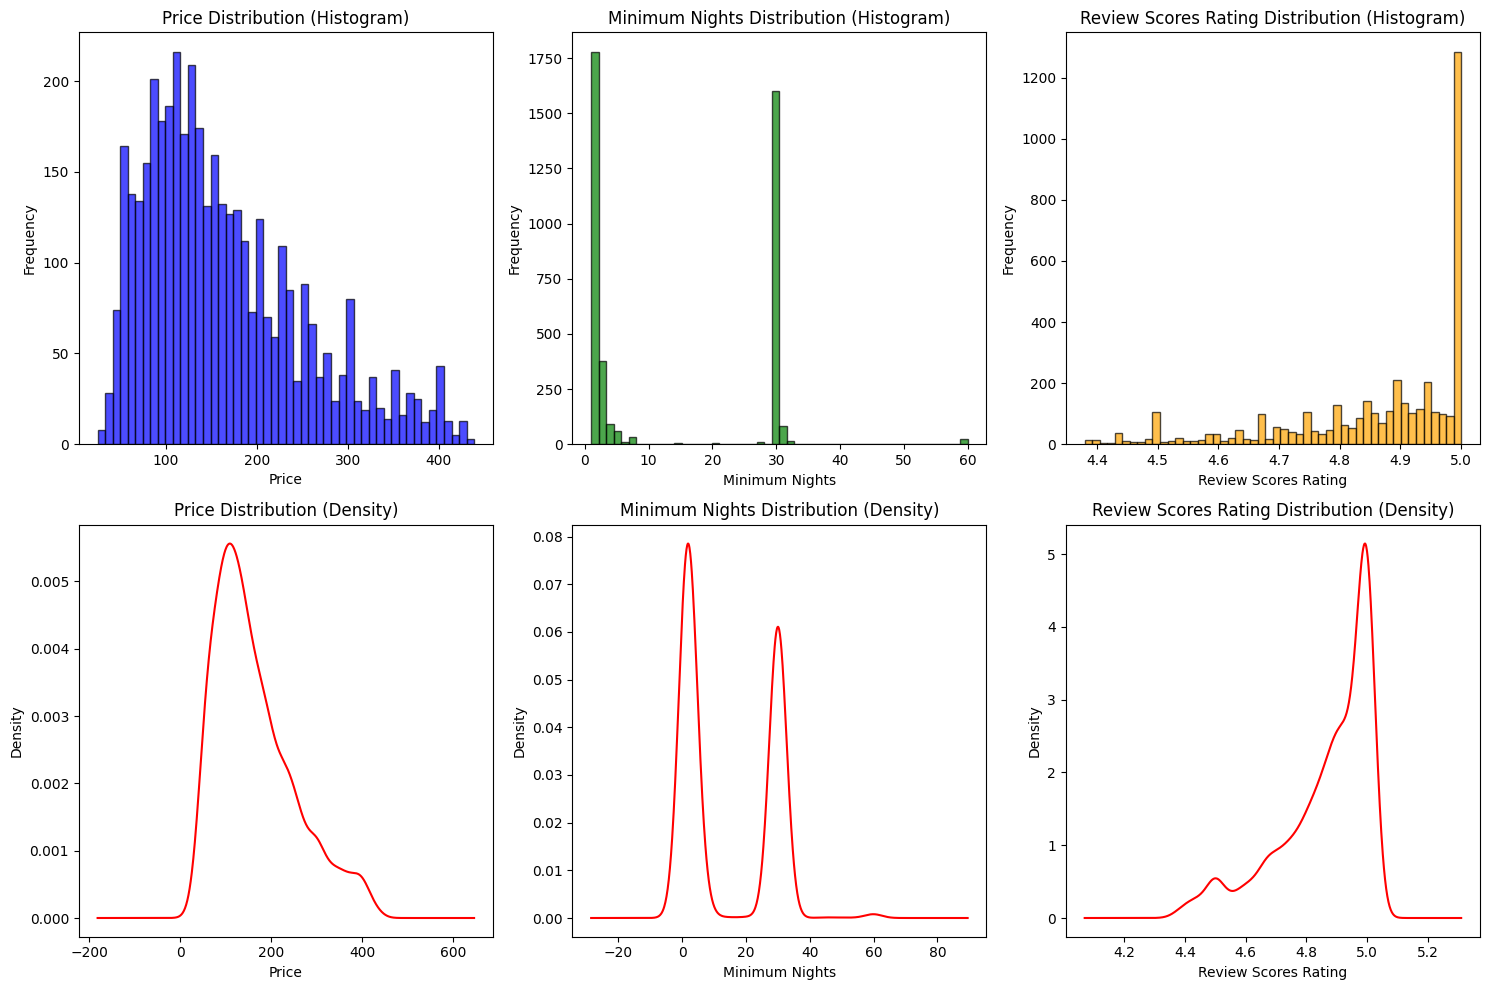

In [57]:
plot_numerical_distributions(listings_no_outliers_IQR)

Visualizing after outlier removal using Z Score

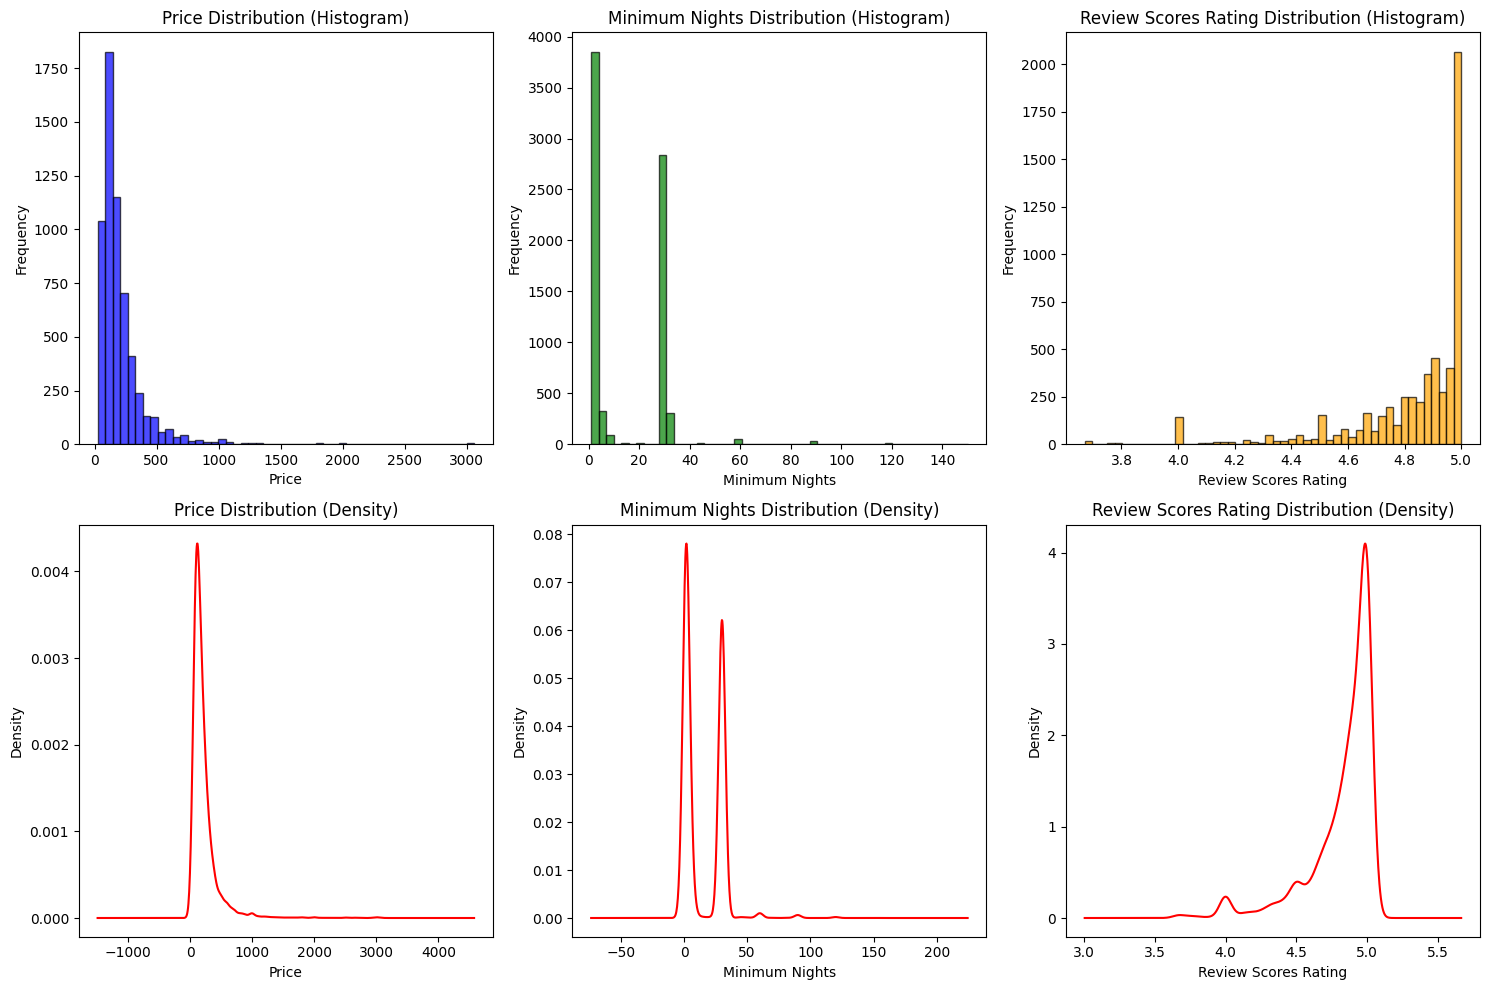

In [58]:
plot_numerical_distributions(listings_no_outliers_Z)

# Text Length

Create a new feature that measures the length of each review (number of words or characters). Determine if the length of a review correlates with its sentiment or the review scores.

<ipython-input-59-4408de321258>:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036 entries, 0 to 6035
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   listing_id               6036 non-null   int64  
 1   avg_review_length_words  6036 non-null   float64
 2   review_scores_rating     6036 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 141.6 KB
None
Correlation between average review length and review score:
                         avg_review_length_words  review_scores_rating
avg_review_length_words                  1.00000              -0.16174
review_scores_rating                    -0.16174               1.00000


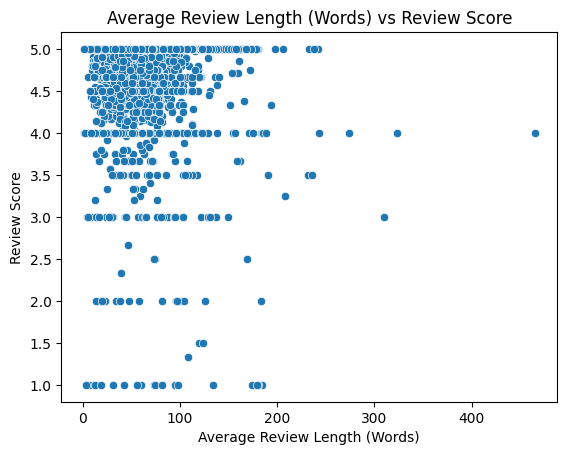

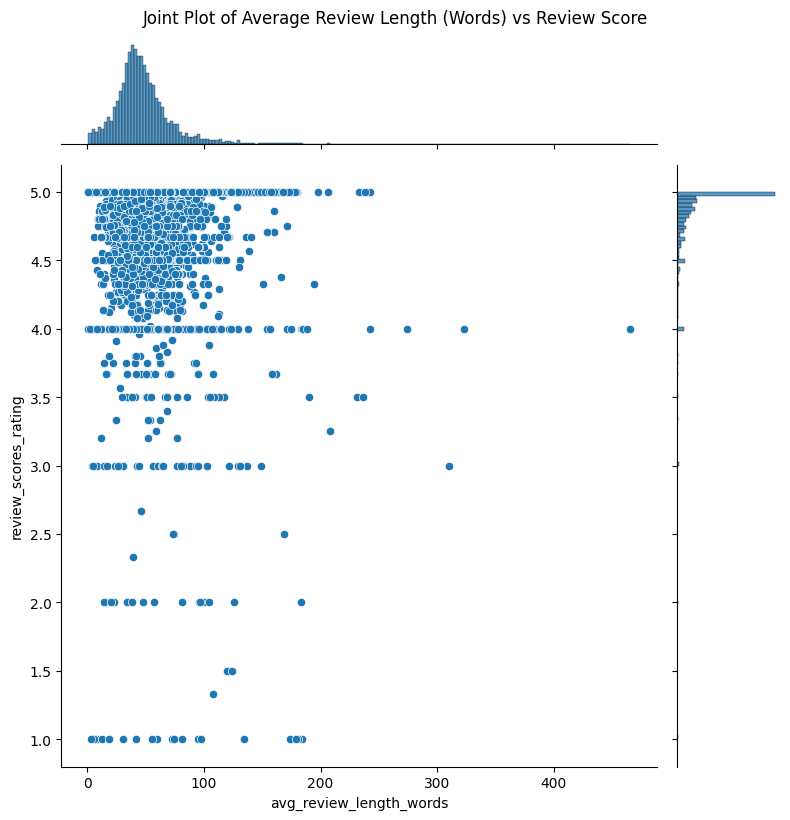

In [59]:
# Duplicate the 'id' column and name it 'listing_id' in listing dataset
listings['listing_id'] = listings['id']

# Fill missing values in the 'comments' column with an empty string
reviews['comments'] = reviews['comments'].fillna('')

# Define a function to clean HTML tags and special characters from the comments
def clean_text(text):
    # Ensure that the text is a string
    if not isinstance(text, str):
        return text

    # Remove HTML tags
    if '<' in text or '>' in text:  # Check if it contains HTML-like tags
        text = BeautifulSoup(text, "html.parser").get_text()

    # Remove special characters (keeping only letters, numbers, and basic punctuation)
    text = re.sub(r'[^A-Za-z0-9.,!?\'\s]', '', text)

    return text

# Apply the cleaning function to the 'comments' column
reviews['comments'] = reviews['comments'].apply(clean_text)

# Calculate the length of each review (both in words and characters)
reviews['review_length_words'] = reviews['comments'].apply(lambda x: len(str(x).split()))
reviews['review_length_chars'] = reviews['comments'].apply(lambda x: len(str(x)))

# Calculate the sentiment polarity of each review
reviews['sentiment'] = reviews['comments'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Group by 'listing_id' and calculate the average review length (in words) for each listing
avg_review_length = reviews.groupby('listing_id')['review_length_words'].mean().reset_index()
avg_review_length.columns = ['listing_id', 'avg_review_length_words']

# Merge the average review length with the cumulative review score from the 'listings' dataset
merged_data = avg_review_length.merge(listings[['listing_id', 'review_scores_rating']], on='listing_id', how='left')

# Drop any rows where review length or review score is missing
merged_data = merged_data.dropna(subset=['avg_review_length_words', 'review_scores_rating'])

# Display the merged data information
print(merged_data.info())

# Calculate the correlation between the average review length and the review score
correlation = merged_data[['avg_review_length_words', 'review_scores_rating']].corr()
print("Correlation between average review length and review score:")
print(correlation)

# Visualize the correlation using a scatter plot
sns.scatterplot(x='avg_review_length_words', y='review_scores_rating', data=merged_data)
plt.title('Average Review Length (Words) vs Review Score')
plt.xlabel('Average Review Length (Words)')
plt.ylabel('Review Score')
plt.show()

# Joint plot to show correlation between average review length and review score
sns.jointplot(x='avg_review_length_words', y='review_scores_rating', data=merged_data, kind='scatter', height=8)
plt.suptitle('Joint Plot of Average Review Length (Words) vs Review Score', y=1.02)
plt.show()


# Keyword Extraction

Identify and count the occurrence of specific keywords (e.g., "clean," "comfortable," "noisy") in the reviews. Generate new features based on the presence of these keywords, which might influence guest satisfaction

In [60]:
# Define positive and negative keywords
positive_keywords = ["great", "clean", "nice", "comfortable", "friendly", "spacious", "amazing", "fabulous"]
negative_keywords = ["uncomfortable", "noisy", "bad", "dirty", "terrible", "unpleasant", "poor"]

# Function to count keyword occurrences in a review, handling NaN values
def count_keywords(review, keywords):
    # Convert the review to a string to avoid errors
    review = str(review).lower()
    # Count occurrences of each keyword
    keyword_counts = {keyword: review.count(keyword) for keyword in keywords}

    return keyword_counts

# Apply the function and convert the result to a DataFrame for positive keywords
positive_keyword_counts_df = reviews["comments"].apply(lambda x: pd.Series(count_keywords(x, positive_keywords)))

# Add the 'positive_' prefix to the column names for positive keywords
positive_keyword_counts_df.columns = ['positive_' + col for col in positive_keyword_counts_df.columns]

# Join the positive keyword counts with the original DataFrame
reviews = reviews.join(positive_keyword_counts_df)

# Apply the function and convert the result to a DataFrame for negative keywords
negative_keyword_counts_df = reviews["comments"].apply(lambda x: pd.Series(count_keywords(x, negative_keywords)))

# Add the 'negative_' prefix to the column names for negative keywords
negative_keyword_counts_df.columns = ['negative_' + col for col in negative_keyword_counts_df.columns]

# Join the negative keyword counts with the original DataFrame
reviews = reviews.join(negative_keyword_counts_df)

# Aggregate keyword counts for each motel
aggregated_reviews = reviews.groupby('listing_id').sum().reset_index()

# Save aggregated reviews to a CSV file
aggregated_reviews.to_csv('aggregated_reviews.csv', index=False)

# List of columns to merge from 'aggregated_reviews'
columns_to_merge = [
    'listing_id', 'positive_great', 'positive_clean', 'positive_nice',
    'positive_comfortable', 'positive_friendly', 'positive_spacious',
    'positive_amazing', 'positive_fabulous', 'negative_uncomfortable',
    'negative_noisy', 'negative_bad', 'negative_dirty', 'negative_terrible',
    'negative_unpleasant', 'negative_poor'
]

# Select only the necessary columns from aggregated_reviews
aggregated_selected = aggregated_reviews[columns_to_merge]

# Merge using 'listing_id' from 'aggregated_reviews' and 'id' from 'listings'
listings = listings.merge(aggregated_selected, left_on='id', right_on='listing_id', how='left')

# Fill NaN values with 0 (in case some motels have no reviews)
listings = listings.fillna(0)

listings.to_csv('listings_with_keywords.csv', index=False)

# Select specific columns to display
columns_to_display = ['id', 'name', 'review_scores_rating'] + [f'positive_{kw}' for kw in positive_keywords] + [f'negative_{kw}' for kw in negative_keywords]
result = listings[columns_to_display]

# Debugging: Print the final result DataFrame
print("Final result DataFrame:")
print(result.head())

# Save the result to a CSV file
result.to_csv('result_keywords.csv', index=False)


Final result DataFrame:
                   id                                               name  \
0            50489368  (B) Furnished Efficiency Studio near Union Square   
1            53687935   2 Private Rooms in SF. Walk to Bart. Modern Home   
2  623833252305593889         Massive 1-bedroom condo in the heart of SF   
3            53817024      Large 1-bedroom in a condo in the heart of SF   
4            54381390                Cozy 1-bedroom condo with roof deck   

   review_scores_rating  positive_great  positive_clean  positive_nice  \
0                  5.00             1.0             0.0            1.0   
1                  4.62            10.0             9.0            9.0   
2                  4.80             3.0             4.0            2.0   
3                  4.87            26.0            10.0            7.0   
4                  5.00             7.0             4.0            1.0   

   positive_comfortable  positive_friendly  positive_spacious  \
0        